<a href="https://colab.research.google.com/github/DrAlexSanz/NLP-SPEC-C2/blob/master/W2/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 2: Parts-of-Speech Tagging (POS)

Welcome to the second assignment of Course 2 in the Natural Language Processing specialization. This assignment will develop skills in part-of-speech (POS) tagging, the process of assigning a part-of-speech tag (Noun, Verb, Adjective...) to each word in an input text. Tagging is difficult because some words can represent more than one part of speech at different times. They are Ambiguous. Let's look at the following example:

* The whole team played well. [adverb]
* You are doing well for yourself. [adjective]
* Well, this assignment took me forever to complete. [interjection]
* The well is dry. [noun]
* Tears were beginning to well in her eyes. [verb]

Distinguishing the parts-of-speech of a word in a sentence will help you better understand the meaning of a sentence. This would be critically important in search queries. Identifying the proper noun, the organization, the stock symbol, or anything similar would greatly improve everything ranging from speech recognition to search. By completing this assignment, you will:

Learn how parts-of-speech tagging works
* Compute the transition matrix A in a Hidden Markov Model
* Compute the transition matrix B in a Hidden Markov Model
* Compute the Viterbi algorithm
* Compute the accuracy of your own model

In [1]:
# Download everything:
!wget https://raw.githubusercontent.com/DrAlexSanz/NLP-SPEC-C2/master/W2/WSJ_02-21.pos
!wget https://raw.githubusercontent.com/DrAlexSanz/NLP-SPEC-C2/master/W2/WSJ_24.pos
!wget https://raw.githubusercontent.com/DrAlexSanz/NLP-SPEC-C2/master/W2/hmm_vocab.txt
!wget https://raw.githubusercontent.com/DrAlexSanz/NLP-SPEC-C2/master/W2/test.words.txt
!wget https://raw.githubusercontent.com/DrAlexSanz/NLP-SPEC-C2/master/W2/utils_pos.py

--2020-10-16 06:06:16--  https://raw.githubusercontent.com/DrAlexSanz/NLP-SPEC-C2/master/W2/WSJ_02-21.pos
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8279089 (7.9M) [text/plain]
Saving to: ‘WSJ_02-21.pos’

WSJ_02-21.pos       100%[===================>]   7.90M  17.2MB/s    in 0.5s    

2020-10-16 06:06:17 (17.2 MB/s) - ‘WSJ_02-21.pos’ saved [8279089/8279089]

--2020-10-16 06:06:17--  https://raw.githubusercontent.com/DrAlexSanz/NLP-SPEC-C2/master/W2/WSJ_24.pos
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286063 (279K) [text/plain]
Sa

In [2]:
import math
import pandas as pd
import numpy as np
from utils_pos import get_word_tag, preprocess
from collections import defaultdict

print("Everything imported correctly")

Everything imported correctly


## Part 0: Data Sources
This assignment will use two tagged data sets collected from the Wall Street Journal (WSJ).

One data set (WSJ-2_21.pos) will be used for training.

The other (WSJ-24.pos) for testing.

The tagged training data has been preprocessed to form a vocabulary (hmm_vocab.txt).

The words in the vocabulary are words from the training set that were used two or more times.

The vocabulary is augmented with a set of 'unknown word tokens', described below.

The training set will be used to create the emission, transmission and tag counts.

The test set (WSJ-24.pos) is read in to create y.

This contains both the test text and the true tag.
The test set has also been preprocessed to remove the tags to form test_words.txt.

This is read in and further processed to identify the end of sentences and handle words not in the vocabulary using functions provided in utils_pos.py.

This forms the list prep, the preprocessed text used to test our POS taggers.
A POS tagger will necessarily encounter words that are not in its datasets.

To improve accuracy, these words are further analyzed during preprocessing to extract available hints as to their appropriate tag.

For example, the suffix 'ize' is a hint that the word is a verb, as in 'final-ize' or 'character-ize'.

A set of unknown-tokens, such as '--unk-verb--' or '--unk-noun--' will replace the unknown words in both the training and test corpus and will appear in the emission, transmission and tag data structures.

Implementation note:

* For python 3.6 and beyond, dictionaries retain the insertion order.
* Furthermore, their hash-based lookup makes them suitable for rapid membership tests.
  * If di is a dictionary, key in di will return True if di has a key key, else False.
* The dictionary vocab will utilize these features.


In [3]:
# Load training corpus

with open("WSJ_02-21.pos", "r") as f:
    training_corpus = f.readlines()

print(f"First 5 lines of the training corpus:", training_corpus[0:5])

First 5 lines of the training corpus: ['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n']


In [4]:
# Read the vocabulary data, split by word (line) and save the vocab

with open("hmm_vocab.txt") as f:
    voc_list = f.read().split("\n")

print(f"The first 5 words", voc_list[0:5])

print(f"The last 5 words", voc_list[-5:])

The first 5 words ['!', '#', '$', '%', '&']
The last 5 words ['zones', 'zoning', '{', '}', '']


In [5]:
# Now make a dictionary of the words in vocab

vocab = {}

for i, word in enumerate(sorted(voc_list)):
    vocab[word] = i

print("Vocabulary dictionary. Key is the word and Value is a unique integer (ID), not a count.")

for k, v in vocab.items():
    print(f"{k}:{v}")

    if v > 10:
        break

Vocabulary dictionary. Key is the word and Value is a unique integer (ID), not a count.
:0
!:1
#:2
$:3
%:4
&:5
':6
'':7
'40s:8
'60s:9
'70s:10
'80s:11


In [6]:
# Load test corpus

with open("WSJ_24.pos", "r") as f:
    test_corpus = f.readlines()

print(f"The first 5 lines of the test corpus:", test_corpus[0:5])

The first 5 lines of the test corpus: ['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n']


In [7]:
# Separate tags from test data

_, prep = preprocess(vocab, "test.words.txt")

In [8]:
print(prep[0:10])

['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


# Part 1: Parts-of-speech tagging

## Part 1.1 - Training
You will start with the simplest possible parts-of-speech tagger and we will build up to the state of the art.

In this section, you will find the words that are not ambiguous.

* For example, the word is is a verb and it is not ambiguous.
* In the WSJ corpus, $86$% of the token are unambiguous (meaning they have only one tag)
* About $14\%$ are ambiguous (meaning that they have more than one tag)

Before you start predicting the tags of each word, you will need to compute a few dictionaries that will help you to generate the tables.

Transition counts
The first dictionary is the transition_counts dictionary which computes the number of times each tag happened next to another tag.
This dictionary will be used to compute:$$P(t_i |t_{i-1}) \tag{1}$$

This is the probability of a tag at position $i$ given the tag at position $i-1$.

In order for you to compute equation 1, you will create a transition_counts dictionary where

The keys are (prev_tag, tag)
The values are the number of times those two tags appeared in that order.
Emission counts
The second dictionary you will compute is the emission_counts dictionary. This dictionary will be used to compute:

$$P(w_i|t_i)\tag{2}$$
In other words, you will use it to compute the probability of a word given its tag.

In order for you to compute equation 2, you will create an emission_counts dictionary where

The keys are (tag, word)
The values are the number of times that pair showed up in your training set.
Tag counts
The last dictionary you will compute is the tag_counts dictionary.

The key is the tag
The value is the number of times each tag appeared.

## Exercise 01
**Instructions:** Write a program that takes in the training_corpus and returns the three dictionaries mentioned above transition_counts, emission_counts, and tag_counts.

**emission_counts:** maps (tag, word) to the number of times it happened.

**transition_counts:** maps (prev_tag, tag) to the number of times it has appeared.

**tag_counts:** maps (tag) to the number of times it has occured.

Implementation note: This routine utilises defaultdict, which is a subclass of dict.

* A standard Python dictionary throws a KeyError if you try to access an item with a key that is not currently in the dictionary.
* In contrast, the defaultdict will create an item of the type of the argument, in this case an integer with the default value of 0.
* See defaultdict.

In [9]:
def create_dicts(training_corpus, vocab):
    """
    Training corpus is an object with a word and a tag per line
    Vocab: Dictionary with the words and a unique key

    Output:
    Emission counts: a dict where the keys are the tuples (tag, word) and the values are the counts
    transition counts: a dict where the keys are the tuples (prev_tag, current_tag) and the values are the number of times this happens.
    tag counts: another dict where the keys are the tags and the values are the counts.
    """

    # First initialize dicts

    emmision_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)

    # I'm going to initialize the previous tag as the start token <S>

    prev_tag = "<S>"

    # Also use i to count the number of lines in training_corpus

    i = 0

    for word_tag in training_corpus:

        i += 1

        if i % 50000 == 0:
            print("Number of lines processed:", i)

        word, tag = get_word_tag(word_tag, vocab)

        # Now increment the prev/current tag count

        emmision_counts[(tag, word)] += 1
        
        transition_counts[(prev_tag, tag)] += 1

        tag_counts[tag] += 1

        prev_tag = tag

    return emmision_counts, transition_counts, tag_counts


In [10]:
emmision_counts, transition_counts, tag_counts = create_dicts(training_corpus, vocab)

Number of lines processed: 50000
Number of lines processed: 100000
Number of lines processed: 150000
Number of lines processed: 200000
Number of lines processed: 250000
Number of lines processed: 300000
Number of lines processed: 350000
Number of lines processed: 400000
Number of lines processed: 450000
Number of lines processed: 500000
Number of lines processed: 550000
Number of lines processed: 600000
Number of lines processed: 650000
Number of lines processed: 700000
Number of lines processed: 750000
Number of lines processed: 800000
Number of lines processed: 850000
Number of lines processed: 900000
Number of lines processed: 950000


In [11]:
states = sorted(tag_counts.keys())
print("Number of POS states:", len(states))
print("Examples of emmision counts:\n", list(emmision_counts.items())[0:5])
print("Examples of transition_counts:\n", list(transition_counts.items())[0:5])
print("Examples of tag counts:\n", list(tag_counts.items())[0:5])

Number of POS states: 46
Examples of emmision counts:
 [(('IN', 'In'), 1735), (('DT', 'an'), 3142), (('NNP', 'Oct.'), 317), (('CD', '19'), 100), (('NN', 'review'), 36)]
Examples of transition_counts:
 [(('<S>', 'IN'), 1), (('IN', 'DT'), 32364), (('DT', 'NNP'), 9044), (('NNP', 'CD'), 1752), (('CD', 'NN'), 7377)]
Examples of tag counts:
 [('IN', 98554), ('DT', 81842), ('NNP', 91466), ('CD', 36568), ('NN', 132935)]


## Part 1.2 - Testing
Now you will test the accuracy of your parts-of-speech tagger using your emission_counts dictionary.

Given your preprocessed test corpus prep, you will assign a parts-of-speech tag to every word in that corpus.
Using the original tagged test corpus y, you will then compute what percent of the tags you got correct.

### Exercise 02
**Instructions:** Implement predict_pos that computes the accuracy of your model.

This is a warm up exercise.

To assign a part of speech to a word, assign the most frequent POS for that word in the training set.
Then evaluate how well this approach works. Each time you predict based on the most frequent POS for the given word, check whether the actual POS of that word is the same. If so, the prediction was correct!
Calculate the accuracy as the number of correct predictions divided by the total number of words for which you predicted the POS tag.

In [12]:
def predict_pos(prep, y, emmision_counts, vocab, states):
    """
    inputs:
    prep: a preprocessed version of y (list with the word part of tuples)
    y: ground truth labels
    emmision counts: a dict where the keys are the tuples (tag, word) and the values are the counts
    vocab: a dictionary where keys are words in vocabulary and value is a unique ID
    states: sorted list of all possible tags (the 46)

    Output:
    The accuracy of the predictions
    """

    # initialize correct
    correct = 0
    # Get all tuples as a set, the tuples are tag, word
    all_words = set(emmision_counts.keys())

    # Count the total amount of words to predict

    total = len(y)

    for word, y_tup in zip(prep, y):

        # Split the word and tag into a list of two items

        y_tup_list = y_tup.split()
        
        # Verify that I got two elements in this list
        if len(y_tup_list) == 2:
            true_label = y_tup_list[1]
        else:
            continue

        # Initialize final count
        count_final = 0
        tag_final = ""

        if word in vocab:
            for tag in states:
                # Define the key as the tuple containing POS tag and word

                key = (tag, word)

                # Check if the key exists in emmision counts (I will put this tag then)

                if key in emmision_counts:
                    count = emmision_counts[key]

                    if count > count_final:
                        count_final = count
                        tag_final = tag

            # If the final tag (highest count) matches the true, I count it as correct
            if tag_final == true_label:
                correct += 1

    accuracy = correct / total

    return accuracy



In [13]:
acc = predict_pos(prep, test_corpus, emmision_counts, vocab, states)

print("Total accuracy is:", round(acc, 2))

Total accuracy is: 0.89


# Part 2: Hidden Markov Models for POS
Now you will build something more context specific. Concretely, you will be implementing a Hidden Markov Model (HMM) with a Viterbi decoder

The HMM is one of the most commonly used algorithms in Natural Language Processing, and is a foundation to many deep learning techniques you will see in this specialization.

In addition to parts-of-speech tagging, HMM is used in speech recognition, speech synthesis, etc.

By completing this part of the assignment you should get a 95% accuracy on the same dataset you used in Part 1.

The Markov Model contains a number of states and the probability of transition between those states.

* In this case, the states are the parts-of-speech.
* A Markov Model utilizes a transition matrix, A.
* A Hidden Markov Model adds an observation or emission matrix B which describes the probability of a visible observation when we are in a particular state.
* In this case, the emissions are the words in the corpus
* The state, which is hidden, is the POS tag of that word.

# Part 2.1 Generating Matrices
Creating the 'A' transition probabilities matrix
Now that you have your emission_counts, transition_counts, and tag_counts, you will start implementing the Hidden Markov Model.

This will allow you to quickly construct the

A transition probabilities matrix.
and the B emission probabilities matrix.
You will also use some smoothing when computing these matrices.

Here is an example of what the A transition matrix would look like (it is simplified to 5 tags for viewing. It is 46x46 in this assignment.):

<table>
<thead>
<tr>
<th><strong>A</strong></th>
<th>...</th>
<th>RBS</th>
<th>RP</th>
<th>SYM</th>
<th>TO</th>
<th>UH</th>
<th>...</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>RBS</strong></td>
<td>...</td>
<td>2.217069e-06</td>
<td>2.217069e-06</td>
<td>2.217069e-06</td>
<td>0.008870</td>
<td>2.217069e-06</td>
<td>...</td>
</tr>
<tr>
<td><strong>RP</strong></td>
<td>...</td>
<td>3.756509e-07</td>
<td>7.516775e-04</td>
<td>3.756509e-07</td>
<td>0.051089</td>
<td>3.756509e-07</td>
<td>...</td>
</tr>
<tr>
<td><strong>SYM</strong></td>
<td>...</td>
<td>1.722772e-05</td>
<td>1.722772e-05</td>
<td>1.722772e-05</td>
<td>0.000017</td>
<td>1.722772e-05</td>
<td>...</td>
</tr>
<tr>
<td><strong>TO</strong></td>
<td>...</td>
<td>4.477336e-05</td>
<td>4.472863e-08</td>
<td>4.472863e-08</td>
<td>0.000090</td>
<td>4.477336e-05</td>
<td>...</td>
</tr>
<tr>
<td><strong>UH</strong></td>
<td>...</td>
<td>1.030439e-05</td>
<td>1.030439e-05</td>
<td>1.030439e-05</td>
<td>0.061837</td>
<td>3.092348e-02</td>
<td>...</td>
</tr>
<tr>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
</tbody>
</table>

Note that the matrix above was computed with smoothing.

Each cell gives you the probability to go from one part of speech to another.

In other words, there is a 4.47e-8 chance of going from parts-of-speech TO to RP.

The sum of each row has to equal 1, because we assume that the next POS tag must be one of the available columns in the table.
The smoothing was done as follows:

$$ P(t_i | t_{i-1}) = \frac{C(t_{i-1}, t_{i}) + \alpha }{C(t_{i-1}) +\alpha * N}\tag{3}$$
* $N$ is the total number of tags
* $C(t_{i-1}, t_{i})$ is the count of the tuple (previous POS, current POS) in transition_counts dictionary.
* $C(t_{i-1})$ is the count of the previous POS in the tag_counts dictionary.
* $\alpha$ is a smoothing parameter.

### Exercise 03
**Instructions:** Implement the create_transition_matrix below for all tags. Your task is to output a matrix that computes equation 3 for each cell in matrix A.

In [14]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    """
    Inputs:
    Alpha --> Number used for smoothing (something like 1e-3 or so, see equation)
    tag_counts --> dictionary where key is a tag and value is the count
    transition_counts --> dictionary where the keys are (prev_tag, tag) and the values are the counts

    Outputs:
    A --> Matrix of dimension (num_tags, num_tags) It's the one shown above
    """

    # Get sorted list of unique tags and count them.
    all_tags = sorted(tag_counts.keys())
    num_tags = len(all_tags)

    # Initialize transition Matrix A with 0

    A = np.zeros((num_tags, num_tags))

    # Get unique transition tuples (from, to)

    trans_keys = set(transition_counts.keys())

    # Go through the matrix updating each cell

    for i in range(num_tags):
        for j in range(num_tags):
            count = 0 # Initialize count of previous, current

            # Get the tuple
            key = (all_tags[i], all_tags[j]) # There's no double indexing in lists!
            
            if key in transition_counts: # If I have the tuple
                count = transition_counts[key]

            # Get the count of the previous tag

            count_prev_tag = tag_counts[all_tags[i]]

            # Smoothing

            A[i, j] = (count + alpha)/(count_prev_tag + alpha * num_tags)

    return A


In [15]:
alpha = 0.001

for i in range(46):
    tag_counts.pop(i, None)

A = create_transition_matrix(alpha, tag_counts, transition_counts)

print(f"At row 0 col 0 we have {A[0, 0]:.9f}")
print(f"At row 3 col 1 we have {A[3, 1]:.9f}")

At row 0 col 0 we have 0.000007040
At row 3 col 1 we have 0.169101919


## Create the 'B' emission probabilities matrix
Now you will create the B transition matrix which computes the emission probability.

You will use smoothing as defined below:

$$P(w_i | t_i) = \frac{C(t_i, word_i)+ \alpha}{C(t_{i}) +\alpha * N}\tag{4}$$

* $C(t_i, word_i)$ is the number of times $word_i$ was associated with $tag_i$ in the training data (stored in emission_counts dictionary).
* $C(t_i)$ is the number of times $tag_i$ was in the training data (stored in tag_counts dictionary).
* $N$ is the number of words in the vocabulary
* $\alpha$ is a smoothing parameter.
* The matrix B is of dimension (num_tags, N), where num_tags is the number of possible parts-of-speech tags.

Here is an example of the matrix, only a subset of tags and words are shown:

## B Emissions Probability Matrix (subset)


<table>
<thead>
<tr>
<th><strong>B</strong></th>
<th>...</th>
<th>725</th>
<th>adroitly</th>
<th>engineers</th>
<th>promoted</th>
<th>synergy</th>
<th>...</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>CD</strong></td>
<td>...</td>
<td><strong>8.201296e-05</strong></td>
<td>2.732854e-08</td>
<td>2.732854e-08</td>
<td>2.732854e-08</td>
<td>2.732854e-08</td>
<td>...</td>
</tr>
<tr>
<td><strong>NN</strong></td>
<td>...</td>
<td>7.521128e-09</td>
<td>7.521128e-09</td>
<td>7.521128e-09</td>
<td>7.521128e-09</td>
<td><strong>2.257091e-05</strong></td>
<td>...</td>
</tr>
<tr>
<td><strong>NNS</strong></td>
<td>...</td>
<td>1.670013e-08</td>
<td>1.670013e-08</td>
<td><strong>4.676203e-04</strong></td>
<td>1.670013e-08</td>
<td>1.670013e-08</td>
<td>...</td>
</tr>
<tr>
<td><strong>VB</strong></td>
<td>...</td>
<td>3.779036e-08</td>
<td>3.779036e-08</td>
<td>3.779036e-08</td>
<td>3.779036e-08</td>
<td>3.779036e-08</td>
<td>...</td>
</tr>
<tr>
<td><strong>RB</strong></td>
<td>...</td>
<td>3.226454e-08</td>
<td><strong>6.456135e-05</strong></td>
<td>3.226454e-08</td>
<td>3.226454e-08</td>
<td>3.226454e-08</td>
<td>...</td>
</tr>
<tr>
<td><strong>RP</strong></td>
<td>...</td>
<td>3.723317e-07</td>
<td>3.723317e-07</td>
<td>3.723317e-07</td>
<td><strong>3.723317e-07</strong></td>
<td>3.723317e-07</td>
<td>...</td>
</tr>
<tr>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
<td>...</td>
</tr>
</tbody>
</table>


### Exercise 04
**Instructions:** Implement the create_emission_matrix below that computes the B emission probabilities matrix. Your function takes in $\alpha$, the smoothing parameter, tag_counts, which is a dictionary mapping each tag to its respective count, the emission_counts dictionary where the keys are (tag, word) and the values are the counts. Your task is to output a matrix that computes equation 4 for each cell in matrix B.

In [20]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    """
    Similar function as the one before. The previous one was to count how many times a given tag is followed by another.
    This one counts how many times a word corresponds to a given tag.
    Inputs:
    Alpha --> Smoothing around 1e-3
    tag_counts --> Dict where the tags are the keys and the counts are the values
    emission_counts --> Dict where the keys are (tag, word) and the values are the counts
    vocab --> Dict where keys are the words, values are a unique ID
    Output:
    B --> Matrix (num_tags, len(vocab)) with the emission probabilities
    """

    # Get num of tags
    num_tags = len(tag_counts)

    # Get a list of tags
    all_tags = sorted(tag_counts.keys())

    num_words = len(vocab)

    # Initialize B

    B = np.zeros((num_tags, num_words)) # Remember this one shouldn't be square!

    # Nested loops to go through the cells

    for i in range(num_tags):
        for j in range(num_words):
          count = 0
          
          # Define which (tag, word) I'm using now
          key = (all_tags[i], vocab[j])

          if key in emission_counts.keys():

            count = emission_counts[key]

          count_tag = tag_counts[all_tags[i]]

          # Apply smoothing
          B[i, j] = (count + alpha)/(count_tag + alpha * num_words) # num_words was len(vocab)

    return B



In [22]:
for i in range(46):
    tag_counts.pop(i, None)

B = create_emission_matrix(alpha, tag_counts, emmision_counts, list(vocab))

print(f"Element 0, 0 of B is: {B[0, 0]:.9f}")
print(f"Element 3, 1 of B is: {B[3, 1]:.9f}")

print("Shape of B is:", B.shape)

Element 0, 0 of B is: 0.000006032
Element 3, 1 of B is: 0.000000720
Shape of B is: (46, 23777)


#Part 3: Viterbi Algorithm and Dynamic Programming
In this part of the assignment you will implement the Viterbi algorithm which makes use of dynamic programming. Specifically, you will use your two matrices, A and B to compute the Viterbi algorithm. We have decomposed this process into three main steps for you.

## Initialization - In this part you initialize the best_paths and best_probabilities matrices that you will be populating in feed_forward.
* Feed forward - At each step, you calculate the probability of each path happening and the best paths up to that point.
* Feed backward: This allows you to find the best path with the highest probabilities.

##Part 3.1: Initialization
You will start by initializing two matrices of the same dimension.

* best_probs: Each cell contains the probability of going from one POS tag to a word in the corpus.

* best_paths: A matrix that helps you trace through the best possible path in the corpus.

### **Exercise 05**
**Instructions:** Write a program below that initializes the best_probs and the best_paths matrix.

Both matrices will be initialized to zero except for column zero of best_probs.

Column zero of best_probs is initialized with the assumption that the first word of the corpus was preceded by a start token ("--s--").
This allows you to reference the A matrix for the transition probability
Here is how to initialize column 0 of best_probs:

* The probability of the best path going from the start index to a given POS tag indexed by integer $i$ is denoted by $\textrm{best_probs}[s_{idx}, i]$.
* This is estimated as the probability that the start tag transitions to the POS denoted by index $i$: $\mathbf{A}[s_{idx}, i]$ AND that the POS tag denoted by $i$ emits the first word of the given corpus, which is $\mathbf{B}[i, vocab[corpus[0]]]$.
* Note that vocab[corpus[0]] refers to the first word of the corpus (the word at position 0 of the corpus).
vocab is a dictionary that returns the unique integer that refers to that particular word.

Conceptually, it looks like this: $\textrm{best_probs}[s_{idx}, i] = \mathbf{A}[s_{idx}, i] \times \mathbf{B}[i, corpus[0] ]$

In order to avoid multiplying and storing small values on the computer, we'll take the log of the product, which becomes the sum of two logs:

$best\_probs[i,0] = log(A[s_{idx}, i]) + log(B[i, vocab[corpus[0]]$

Also, to avoid taking the log of 0 (which is defined as negative infinity), the code itself will just set $best\_probs[i,0] = float('-inf')$ when $A[s_{idx}, i] == 0$

So the implementation to initialize $best\_probs$ looks like this:

$ if A[s_{idx}, i]  0 : best\_probs[i,0] = log(A[s_{idx}, i]) + log(B[i, vocab[corpus[0]]$

$ if A[s_{idx}, i] == 0 : best\_probs[i,0] = float('-inf')$

Please use math.log to compute the natural logarithm.

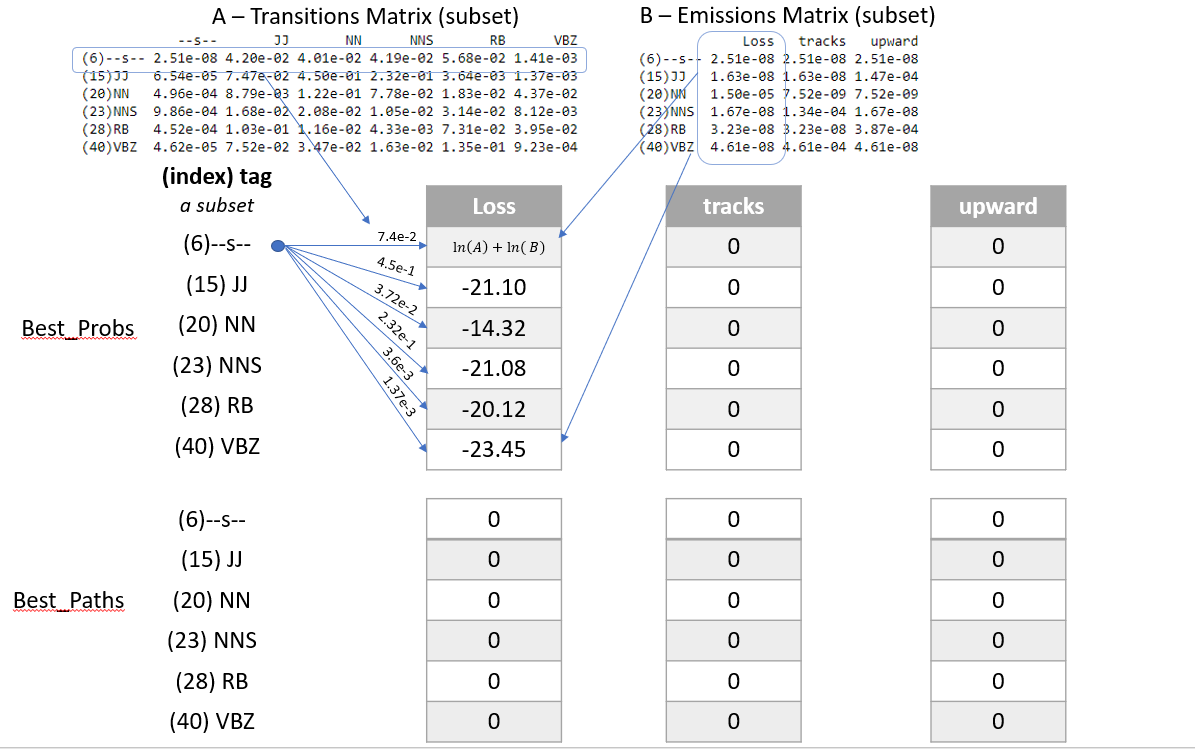